In [ ]:
!pip install timm


# Tea Quality Estimation (Regression)

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import timm  # For DINO models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import time
import torch.optim as optim
from tqdm import tqdm

In [10]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from PIL import Image

# Custom Dataset to extract prices from file names
class TeaDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [
            f for f in os.listdir(folder_path) if f.endswith('.jpg')
        ]
        self.prices = [
            float(f.split()[2]) for f in self.image_files
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        price = self.prices[idx]
        return image, price

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Load the dataset
dataset_path = '/kaggle/input/sampled-tea-full/Sampled_full/Train'
train_dataset = TeaDataset(folder_path=dataset_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the dataset
dataset_path = '/kaggle/input/sampled-tea-full/Sampled_full/Val'
val_dataset = TeaDataset(folder_path=dataset_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


# Load the pre-trained DinoV2 model
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
dinov2_model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dinov2_model = dinov2_model.to(device)

# Feature extraction function
def extract_features_dinov2(model, dataloader, device):
    cls_features_list = []
    price_list = []
    with torch.no_grad():
        for images, prices in dataloader:
            images = images.to(device)

            # Forward pass through the model
            output = model.forward_features(images)
            cls_tokens = output['x_norm_clstoken']

            cls_features_list.append(cls_tokens.cpu())
            price_list.append(prices)

    # Concatenate all features and prices
    cls_features = torch.cat(cls_features_list, dim=0)
    prices = torch.cat(price_list, dim=0)

    return cls_features, prices






Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [ ]:
# Extract features and prices
cls_features, prices = extract_features_dinov2(dinov2_model, tea_loader, device)

# Convert features and prices to numpy
cls_features_np = cls_features.numpy()
prices_np = prices.numpy()

# Using tsne for dimension reduction

In [ ]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
cls_features_2d = tsne.fit_transform(cls_features_np)

# Visualize the features with t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(cls_features_2d[:, 0], cls_features_2d[:, 1], c=prices_np, cmap='viridis', s=50)
plt.colorbar(scatter, label='Price')
plt.title('t-SNE Visualization of Tea Sample Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Training Set 

In [9]:
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=3, random_state=42)
cls_features_3d = tsne.fit_transform(cls_features_np)  # Already a NumPy array

# Create a DataFrame for visualization
data = {
    'x': cls_features_3d[:, 0],
    'y': cls_features_3d[:, 1],
    'z': cls_features_3d[:, 2],
    'label': prices_np  # Use the prices as the color label
}
df = pd.DataFrame(data)

# Create a 3D scatter plot
fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', title='3D Visualization of Reduced Features')

# Show the plot
fig.show()


In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from PIL import Image

# Custom Dataset to extract prices from file names
class TeaDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [
            f for f in os.listdir(folder_path) if f.endswith('.jpg')
        ]
        self.prices = [
            float(f.split()[2]) for f in self.image_files
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        price = self.prices[idx]
        return image, price

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Load the dataset
dataset_path = '/kaggle/input/sampled-tea-full/Sampled_full/Val'
tea_dataset = TeaDataset(folder_path=dataset_path, transform=transform)
tea_loader = DataLoader(tea_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the pre-trained DinoV2 model
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
dinov2_model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dinov2_model = dinov2_model.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_reg4_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 143MB/s] 


## Validation Set 

In [4]:

# Extract features and prices
cls_features, prices = extract_features_dinov2(dinov2_model, tea_loader, device)

# Convert features and prices to numpy
cls_features_np = cls_features.numpy()
prices_np = prices.numpy()

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
cls_features_2d = tsne.fit_transform(cls_features_np)

# Visualize the features with t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(cls_features_2d[:, 0], cls_features_2d[:, 1], c=prices_np, cmap='viridis', s=50)
plt.colorbar(scatter, label='Price')
plt.title('t-SNE Visualization of Tea Sample Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


NameError: name 'tea_loader' is not defined

In [11]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=3, random_state=42)
cls_features_3d = tsne.fit_transform(cls_features_np)  # Already a NumPy array

# Create a DataFrame for visualization
data = {
    'x': cls_features_3d[:, 0],
    'y': cls_features_3d[:, 1],
    'z': cls_features_3d[:, 2],
    'label': prices_np  # Use the prices as the color label
}
df = pd.DataFrame(data)

# Create a 3D scatter plot
fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', title='3D Visualization of Reduced Features')

# Show the plot
fig.show()


# Using Autoencoders

In [4]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder to reduce features to 2 dimensions
        self.encoder = nn.Sequential(
            nn.Linear(384, 512),  # Match DINOv2 CLS token size
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 3)  # Reduce to 2 dimensions
        )
        # Decoder to reconstruct features (optional, for training)
        self.decoder = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 384)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return encoded, reconstructed

# Initialize the autoencoder model
autoencoder = Autoencoder().to(device)

In [114]:
def train_autoencoder(autoencoder, dinov2_model, dataloader, device, optimizer, criterion, epochs=10, threshold=0.3):
    autoencoder.train()
    for epoch in range(epochs):
        epoch_loss = 0
        correct_samples = 0
        total_samples = 0
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        for images, _ in pbar:  # We don't need labels for the autoencoder
            images = images.to(device)

            # Extract CLS tokens from the DINOv2 model
            with torch.no_grad():
                output = dinov2_model.forward_features(images)
                cls_tokens = output['x_norm_clstoken']

            # Forward pass through the autoencoder
            optimizer.zero_grad()
            encoded, reconstructed = autoencoder(cls_tokens)
            loss = criterion(reconstructed, cls_tokens)  # Compare reconstructed features with input
            loss.backward()
            optimizer.step()

            # Update progress
            pbar.set_postfix(loss=loss.item())
            epoch_loss += loss.item()

            # Calculate reconstruction error
            reconstruction_error = torch.mean((reconstructed - cls_tokens) ** 2, dim=1)
            
            # Debug: Print reconstruction errors for the first epoch
            if epoch == 0 and total_samples == 0:
                print("Reconstruction Errors (Sample):", reconstruction_error[:5].detach().cpu().numpy())

            # Update accuracy
            correct_samples += (reconstruction_error < threshold).sum().item()
            total_samples += images.size(0)

        # Compute epoch accuracy
        accuracy = (correct_samples / total_samples) * 100

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss / len(dataloader):.4f}, Accuracy: {accuracy:.2f}%")



# Define optimizer and loss function
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)  # Optimizer
criterion = nn.MSELoss()  # Loss function

In [18]:


# Train the autoencoder
train_autoencoder(autoencoder, dinov2_model, tea_loader, device, optimizer, criterion, epochs=20)


Epoch 1/20:   1%|          | 2/168 [00:00<00:54,  3.03it/s, loss=0.329]

Reconstruction Errors (Sample): [0.11124393 0.24166715 0.15239021 0.13316178 0.1761753 ]


Epoch 1/20 - Loss: 0.1737, Accuracy: 97.72%


Epoch 2/20 - Loss: 0.1630, Accuracy: 98.91%


Epoch 3/20 - Loss: 0.1594, Accuracy: 98.99%


Epoch 4/20 - Loss: 0.1573, Accuracy: 99.18%


Epoch 5/20 - Loss: 0.1555, Accuracy: 99.23%


Epoch 6/20 - Loss: 0.1540, Accuracy: 99.33%


Epoch 7/20 - Loss: 0.1528, Accuracy: 99.36%


Epoch 8/20 - Loss: 0.1517, Accuracy: 99.35%


Epoch 9/20 - Loss: 0.1513, Accuracy: 99.40%


Epoch 10/20 - Loss: 0.1506, Accuracy: 99.42%


Epoch 11/20 - Loss: 0.1502, Accuracy: 99.46%


Epoch 12/20 - Loss: 0.1494, Accuracy: 99.48%


Epoch 13/20 - Loss: 0.1489, Accuracy: 99.49%


Epoch 14/20 - Loss: 0.1480, Accuracy: 99.53%


Epoch 15/20 - Loss: 0.1475, Accuracy: 99.53%


Epoch 16/20 - Loss: 0.1473, Accuracy: 99.48%


Epoch 17/20 - Loss: 0.1471, Accuracy: 99.42%


Epoch 18/20 - Loss: 0.1463, Accuracy: 99.55%


Epoch 19/20 - Loss: 0.1459, Accuracy: 99.55%


Epoch 20/20 - Loss: 0.1454, Accuracy: 99.61%


In [13]:
# Feature extraction function
def extract_features_dinov2(model, dataloader, device, autoencoder):
    cls_features_list = []
    price_list = []
    with torch.no_grad():
        for images, prices in dataloader:
            images = images.to(device)

            # Forward pass through the model
            output = model.forward_features(images)
            cls_tokens = output['x_norm_clstoken']
            reduced_features, _ = autoencoder(cls_tokens)

            cls_features_list.append(reduced_features.cpu())
            price_list.append(prices)

    # Concatenate all features and prices
    cls_features = torch.cat(cls_features_list, dim=0)
    prices = torch.cat(price_list, dim=0)

    return cls_features, prices

## Training Set

In [39]:
cls_features_3d, prices_np = extract_features_dinov2(dinov2_model, tea_loader, device, autoencoder)


In [40]:
# Create a DataFrame for visualization
data = {
    'x': cls_features_3d[:, 0],
    'y': cls_features_3d[:, 1],
    'z': cls_features_3d[:, 2],
    'label': prices_np  # Use the prices as the color label
}
df = pd.DataFrame(data)

# Create a 3D scatter plot
fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', title='3D Visualization of Reduced Features')

# Show the plot
fig.show()


## Validation Set

In [41]:
cls_features_3d, prices = extract_features_dinov2(dinov2_model, tea_loader, device, autoencoder)

In [42]:
# Create a DataFrame for visualization
data = {
    'x': cls_features_3d[:, 0],
    'y': cls_features_3d[:, 1],
    'z': cls_features_3d[:, 2],
    'label': prices  # Use the prices as the color label
}
df = pd.DataFrame(data)

# Create a 3D scatter plot
fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', title='3D Visualization of Reduced Features')

# Show the plot
fig.show()


In [10]:
#Extract features and prices for training data
train_features, train_prices = extract_features_dinov2(dinov2_model, train_loader, device)

# Convert features and prices to numpy arrays
train_features_np = train_features.numpy()
train_prices_np = train_prices.numpy()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_features_np, train_prices_np, test_size=0.2, random_state=42)

# Train a Random Forest regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)

# Validate the model
y_pred = regressor.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 10463.138783910195


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_features_np, train_prices_np, test_size=0.2, random_state=42)

# Simulated "epochs" by incrementing the number of trees
n_estimators_list = [10, 20, 50, 100, 150, 200]  # Number of trees
training_errors = []
validation_errors = []

for n_estimators in n_estimators_list:
    # Train a Random Forest regressor with the current number of trees
    regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    regressor.fit(X_train, y_train)
    
    # Evaluate on training data
    y_train_pred = regressor.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    training_errors.append(train_mse)
    
    # Evaluate on validation data
    y_val_pred = regressor.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    validation_errors.append(val_mse)

    print(f"Trees: {n_estimators}, Training MSE: {train_mse}, Validation MSE: {val_mse}")

# Plot training and validation errors
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, training_errors, label='Training MSE', marker='o')
plt.plot(n_estimators_list, validation_errors, label='Validation MSE', marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Errors vs Number of Trees')
plt.legend()
plt.grid()
plt.show()


Trees: 10, Training MSE: 2687.3196913002807, Validation MSE: 13014.526660430309
Trees: 20, Training MSE: 2063.633126753976, Validation MSE: 11514.778297474275
Trees: 50, Training MSE: 1723.6240692235733, Validation MSE: 10645.968942937325
Trees: 100, Training MSE: 1635.4008793264734, Validation MSE: 10463.138783910195


KeyboardInterrupt: 

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate accuracy percentage
def calculate_accuracy(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy = 100 - mape
    return accuracy

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_features_np, train_prices_np, test_size=0.2, random_state=42)

# Simulated "epochs" by incrementing the number of trees
n_estimators_list = [10, 20, 50, 100, 150, 200]  # Number of trees
training_accuracies = []
validation_accuracies = []

for n_estimators in n_estimators_list:
    # Train a Random Forest regressor with the current number of trees
    regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    regressor.fit(X_train, y_train)
    
    # Evaluate on training data
    y_train_pred = regressor.predict(X_train)
    train_accuracy = calculate_accuracy(y_train, y_train_pred)
    training_accuracies.append(train_accuracy)
    
    # Evaluate on validation data
    y_val_pred = regressor.predict(X_val)
    val_accuracy = calculate_accuracy(y_val, y_val_pred)
    validation_accuracies.append(val_accuracy)

    print(f"Trees: {n_estimators}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, training_accuracies, label='Training Accuracy', marker='o')
plt.plot(n_estimators_list, validation_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy vs Number of Trees')
plt.legend()
plt.grid()
plt.show()


KeyboardInterrupt: 

In [12]:

#Extract features and prices for training data
train_features, train_prices = extract_features_dinov2(dinov2_model, train_loader, device, autoencoder)
val_features, val_prices = extract_features_dinov2(dinov2_model, val_loader, device, autoencoder)

# Convert features and prices to numpy arrays
train_features_np = train_features.numpy()
train_prices_np = train_prices.numpy()

val_features_np = val_features.numpy()
val_prices_np = val_prices.numpy()


TypeError: extract_features_dinov2() takes 3 positional arguments but 4 were given

Trees: 20, Training Accuracy: 97.68%, Validation Accuracy: 93.81%
Trees: 50, Training Accuracy: 97.83%, Validation Accuracy: 94.05%
Trees: 100, Training Accuracy: 97.90%, Validation Accuracy: 94.11%
Trees: 150, Training Accuracy: 97.90%, Validation Accuracy: 94.09%


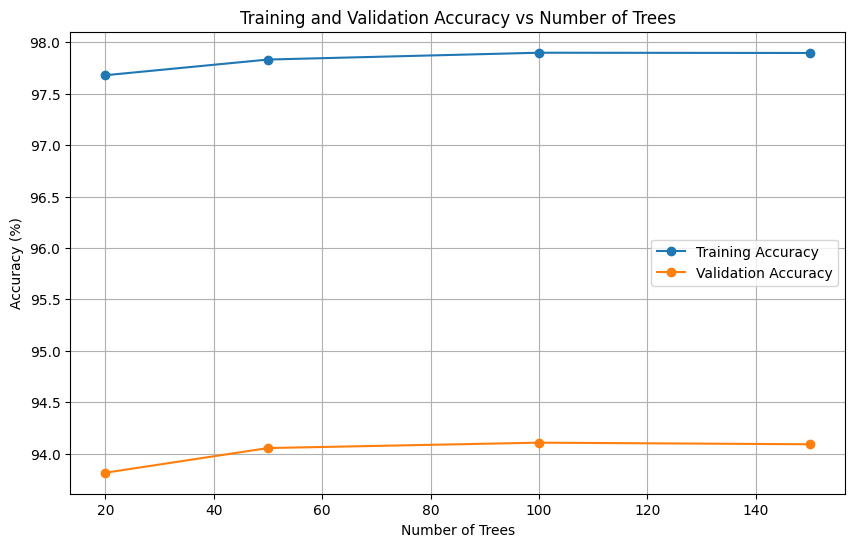

In [17]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_features_np,val_features_np,train_prices_np,val_prices_np

# Simulated "epochs" by incrementing the number of trees
n_estimators_list = [20, 50, 100, 150]  # Number of trees
training_accuracies = []
validation_accuracies = []

for n_estimators in n_estimators_list:
    # Train a Random Forest regressor with the current number of trees
    regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    regressor.fit(X_train, y_train)
    
    # Evaluate on training data
    y_train_pred = regressor.predict(X_train)
    train_accuracy = calculate_accuracy(y_train, y_train_pred)
    training_accuracies.append(train_accuracy)
    
    # Evaluate on validation data
    y_val_pred = regressor.predict(X_val)
    val_accuracy = calculate_accuracy(y_val, y_val_pred)
    validation_accuracies.append(val_accuracy)

    print(f"Trees: {n_estimators}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, training_accuracies, label='Training Accuracy', marker='o')
plt.plot(n_estimators_list, validation_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy vs Number of Trees')
plt.legend()
plt.grid()
plt.show()


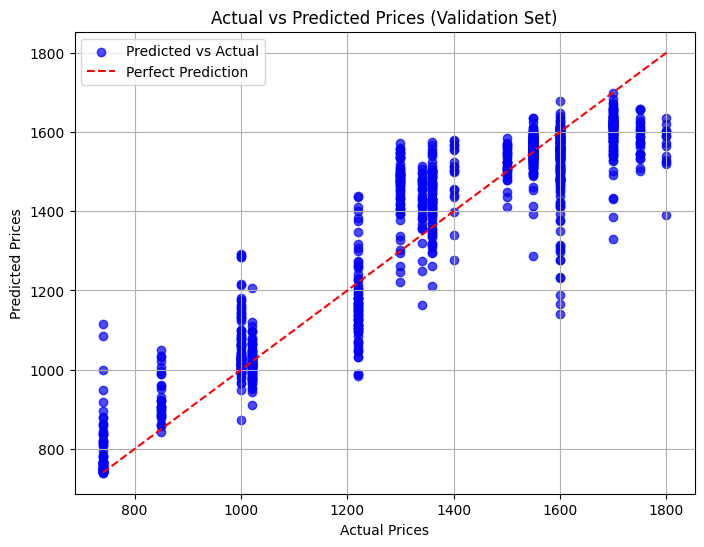

In [19]:

# Evaluate on validation data
y_train_pred = regressor.predict(X_train)

# Plot Actual vs Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_val_pred, color='blue', label='Predicted vs Actual', alpha=0.7)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Validation Set)')
plt.legend()
plt.grid()
plt.show()


In [91]:
# Custom Dataset to extract prices and lot numbers from file names
class TeaDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [
            f for f in os.listdir(folder_path) if f.endswith('.jpg')
        ]
        # Assuming the filename format is like "some_name_lotnumber_price.jpg"
        self.prices = [
            float(f.split()[2]) for f in self.image_files  # Adjust according to your filename structure
        ]
        self.lot_numbers = [
            float(f.split()[1]) for f in self.image_files  # Handle lot number as float first
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        price = self.prices[idx]
        lot_number = int(self.lot_numbers[idx])  # Convert lot number to int after extracting it as float
        return image, price, lot_number


In [92]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Load the dataset
dataset_path = '/kaggle/input/sampled-tea-full/Sampled_full/Train'
train_dataset = TeaDataset(folder_path=dataset_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load the dataset
dataset_path = '/kaggle/input/sampled-tea-full/Sampled_full/Val'
val_dataset = TeaDataset(folder_path=dataset_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


# Load the pre-trained DinoV2 model
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
dinov2_model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dinov2_model = dinov2_model.to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [44]:
def extract_features_dinov2_with_label(model, dataloader, device):
    cls_features_list = []
    price_list = []
    lot_number_list = []

    with torch.no_grad():
        for images, prices, lot_numbers in dataloader:
            images = images.to(device)

            # Forward pass through the model
            output = model.forward_features(images)
            cls_tokens = output['x_norm_clstoken']

            cls_features_list.append(cls_tokens.cpu())
            price_list.append(prices)
            lot_number_list.append(torch.tensor(lot_numbers))  # Ensure lot_numbers are tensors

    # Concatenate all features, prices, and lot numbers
    cls_features = torch.cat(cls_features_list, dim=0)
    prices = torch.cat(price_list, dim=0)
    lot_numbers = torch.cat(lot_number_list, dim=0)

    return cls_features, prices, lot_numbers


In [93]:
#Extract features and prices for training data
train_features, train_prices,train_lot_numbers  = extract_features_dinov2_with_label(dinov2_model, train_loader, device)
val_features, val_prices, val_lot_numbers = extract_features_dinov2_with_label(dinov2_model, val_loader, device)

# Convert features and prices to numpy arrays
train_features_np = train_features.numpy()
train_prices_np = train_prices.numpy()
train_lot_numbers_np = train_lot_numbers.numpy()


val_features_np = val_features.numpy()
val_prices_np = val_prices.numpy()
val_lot_numbers_np = val_lot_numbers.numpy()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-44-5c63c4398c89>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lot_number_list.append(torch.tensor(lot_numbers))  # Ensure lot_numbers are tensors


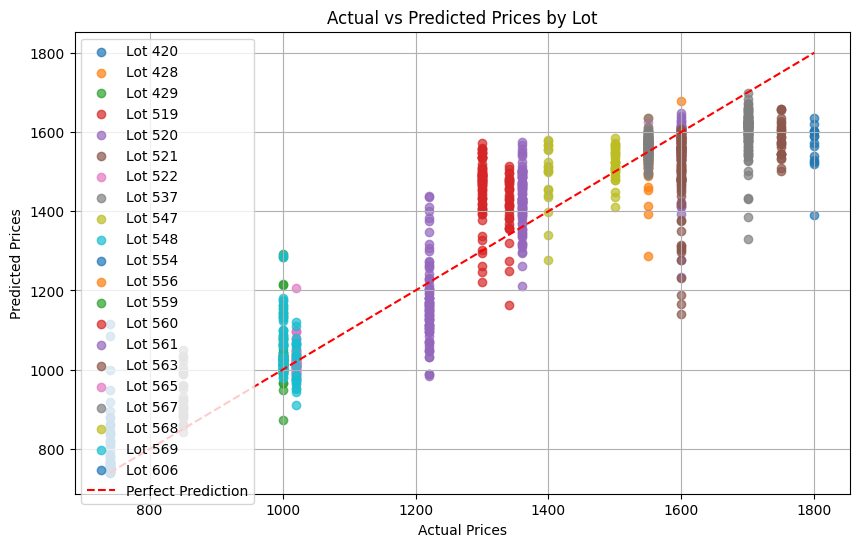

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example: Get predictions for the validation set
regressor = RandomForestRegressor(n_estimators=150, random_state=42)
regressor.fit(X_train, y_train)  # Train on your dataset

# Predict on validation data
y_val_pred = regressor.predict(X_val)

# Create a DataFrame for actual and predicted prices, with lot numbers
df = pd.DataFrame({
    'Actual Price': y_val,
    'Predicted Price': y_val_pred,
    'Lot Number': val_lot_numbers_np,  # Replace with actual lot numbers
})

# Calculate the average predicted price for each lot
avg_pred_price_by_lot = df.groupby('Lot Number')['Predicted Price'].mean()

# Visualize actual vs predicted prices for each lot
plt.figure(figsize=(10, 6))
for lot in avg_pred_price_by_lot.index:
    actual_prices_for_lot = df[df['Lot Number'] == lot]['Actual Price']
    predicted_prices_for_lot = df[df['Lot Number'] == lot]['Predicted Price']
    
    plt.scatter(actual_prices_for_lot, predicted_prices_for_lot, label=f'Lot {lot}', alpha=0.7)

# Add perfect prediction line
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices by Lot')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

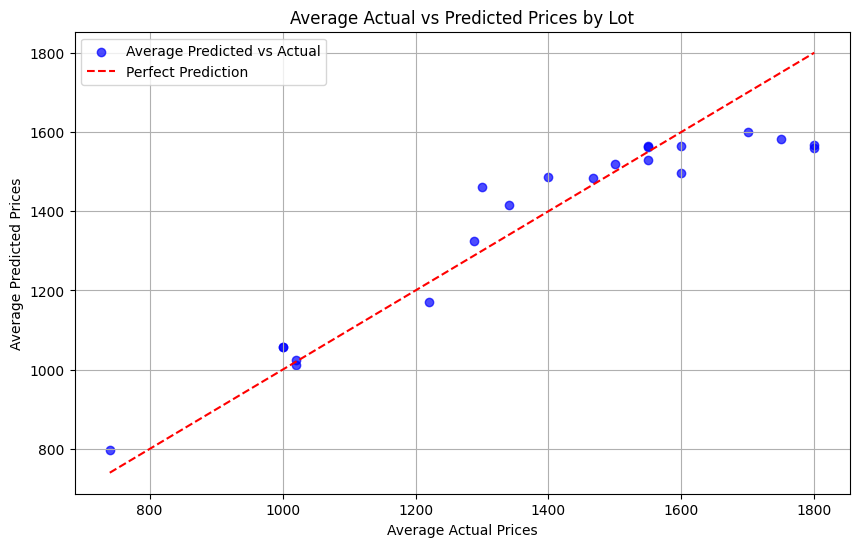

Accuracy of Predicted Averages: 94.65%


In [53]:


# Example: Get predictions for the validation set
regressor = RandomForestRegressor(n_estimators=150, random_state=42)
regressor.fit(X_train, y_train)  # Train on your dataset

# Predict on validation data
y_val_pred = regressor.predict(X_val)

# Create a DataFrame for actual and predicted prices, with lot numbers
df = pd.DataFrame({
    'Actual Price': y_val,
    'Predicted Price': y_val_pred,
    'Lot Number': val_lot_numbers_np,  # Replace with actual lot numbers
})

# Calculate the average predicted price and actual price for each lot
avg_actual_price_by_lot = df.groupby('Lot Number')['Actual Price'].mean()
avg_pred_price_by_lot = df.groupby('Lot Number')['Predicted Price'].mean()

# Calculate the accuracy of the predicted average vs true average
# Mean Absolute Error (MAE) between actual and predicted averages for each lot
mae = mean_absolute_error(avg_actual_price_by_lot, avg_pred_price_by_lot)
accuracy = 100 - (mae / avg_actual_price_by_lot.mean()) * 100

# Visualize the average actual vs predicted prices for each lot
plt.figure(figsize=(10, 6))
plt.scatter(avg_actual_price_by_lot, avg_pred_price_by_lot, color='blue', label='Average Predicted vs Actual', alpha=0.7)
plt.plot([min(avg_actual_price_by_lot), max(avg_actual_price_by_lot)], 
         [min(avg_actual_price_by_lot), max(avg_actual_price_by_lot)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Average Actual Prices')
plt.ylabel('Average Predicted Prices')
plt.title('Average Actual vs Predicted Prices by Lot')
plt.legend()
plt.grid(True)
plt.show()

# Print accuracy of predicted average prices
print(f"Accuracy of Predicted Averages: {accuracy:.2f}%")


# Regression on Dim reduced Features

## 10D

In [112]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder to reduce features to 2 dimensions
        self.encoder = nn.Sequential(
            nn.Linear(384, 512),  # Match DINOv2 CLS token size
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # Reduce to 2 dimensions
        )
        # Decoder to reconstruct features (optional, for training)
        self.decoder = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 384)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return encoded, reconstructed

# Initialize the autoencoder model
autoencoder = Autoencoder().to(device)

In [115]:
# Train the autoencoder
train_autoencoder(autoencoder, dinov2_model, tea_loader, device, optimizer, criterion, epochs=20)

Epoch 1/20:   6%|▌         | 2/35 [00:00<00:10,  3.00it/s, loss=1.69]

Reconstruction Errors (Sample): [1.6952045 1.7089655 1.7689428 1.7571228 1.7672346]


Epoch 1/20 - Loss: 0.5016, Accuracy: 44.41%


Epoch 2/20 - Loss: 0.2305, Accuracy: 83.88%


Epoch 3/20 - Loss: 0.2026, Accuracy: 93.32%


Epoch 4/20 - Loss: 0.1977, Accuracy: 94.69%


Epoch 5/20 - Loss: 0.1837, Accuracy: 97.44%


Epoch 6/20 - Loss: 0.1701, Accuracy: 98.90%


Epoch 7/20 - Loss: 0.1584, Accuracy: 99.18%


Epoch 8/20 - Loss: 0.1473, Accuracy: 99.73%


Epoch 9/20 - Loss: 0.1411, Accuracy: 99.91%


Epoch 10/20 - Loss: 0.1369, Accuracy: 99.91%


Epoch 11/20 - Loss: 0.1323, Accuracy: 99.91%


Epoch 12/20 - Loss: 0.1266, Accuracy: 99.91%


Epoch 13/20 - Loss: 0.1213, Accuracy: 99.91%


Epoch 14/20 - Loss: 0.1169, Accuracy: 100.00%


Epoch 15/20 - Loss: 0.1139, Accuracy: 100.00%


Epoch 16/20 - Loss: 0.1115, Accuracy: 100.00%


Epoch 17/20 - Loss: 0.1099, Accuracy: 100.00%


Epoch 18/20 - Loss: 0.1083, Accuracy: 100.00%


Epoch 19/20 - Loss: 0.1071, Accuracy: 100.00%


Epoch 20/20 - Loss: 0.1067, Accuracy: 100.00%


In [116]:
def extract_features_dinov2_with_label_encoder(model, dataloader, device,autoencoder):
    cls_features_list = []
    price_list = []
    lot_number_list = []

    with torch.no_grad():
        for images, prices, lot_numbers in dataloader:
            images = images.to(device)

            # Forward pass through the model
            output = model.forward_features(images)
            cls_tokens = output['x_norm_clstoken']
            reduced_features, _ = autoencoder(cls_tokens)

            cls_features_list.append(reduced_features.cpu())
            price_list.append(prices)
            lot_number_list.append(torch.tensor(lot_numbers))  # Ensure lot_numbers are tensors

    # Concatenate all features, prices, and lot numbers
    cls_features = torch.cat(cls_features_list, dim=0)
    prices = torch.cat(price_list, dim=0)
    lot_numbers = torch.cat(lot_number_list, dim=0)

    return cls_features, prices, lot_numbers


In [117]:
#Extract features and prices for training data
train_features, train_prices,train_lot_numbers = extract_features_dinov2_with_label_encoder(dinov2_model, train_loader, device,autoencoder)
val_features, val_prices , val_lot_numbers= extract_features_dinov2_with_label_encoder(dinov2_model, val_loader, device,autoencoder)

# Convert features and prices to numpy arrays
train_features_np = train_features.numpy()
train_prices_np = train_prices.numpy()
train_lot_numbers_np = train_lot_numbers.numpy()


val_features_np = val_features.numpy()
val_prices_np = val_prices.numpy()
val_lot_numbers_np = val_lot_numbers.numpy()

<ipython-input-116-07838be351ac>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lot_number_list.append(torch.tensor(lot_numbers))  # Ensure lot_numbers are tensors


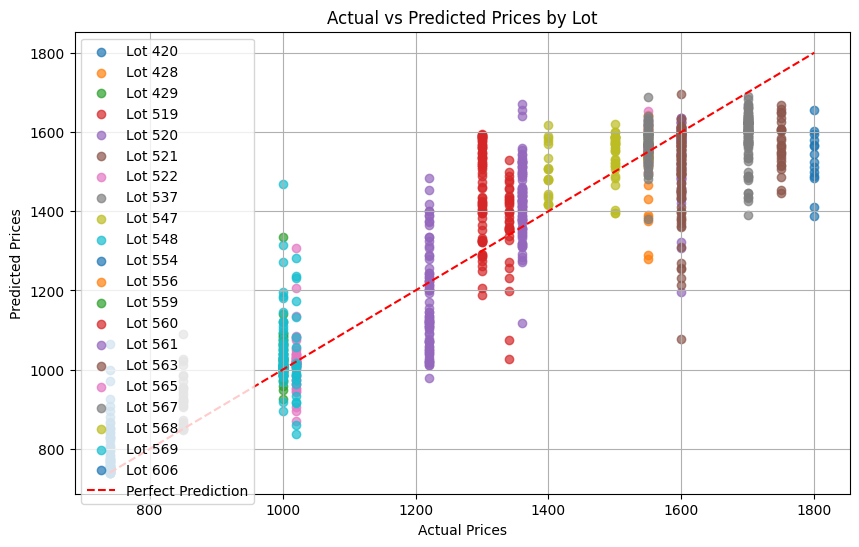

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


X_train, X_val, y_train, y_val = train_features_np,val_features_np,train_prices_np,val_prices_np
# Example: Get predictions for the validation set
regressor = RandomForestRegressor(n_estimators=150, random_state=42)
regressor.fit(X_train, y_train)  # Train on your dataset

# Predict on validation data
y_val_pred = regressor.predict(X_val)

# Create a DataFrame for actual and predicted prices, with lot numbers
df = pd.DataFrame({
    'Actual Price': y_val,
    'Predicted Price': y_val_pred,
    'Lot Number': val_lot_numbers_np,  # Replace with actual lot numbers
})

# Calculate the average predicted price for each lot
avg_pred_price_by_lot = df.groupby('Lot Number')['Predicted Price'].mean()

# Visualize actual vs predicted prices for each lot
plt.figure(figsize=(10, 6))
for lot in avg_pred_price_by_lot.index:
    actual_prices_for_lot = df[df['Lot Number'] == lot]['Actual Price']
    predicted_prices_for_lot = df[df['Lot Number'] == lot]['Predicted Price']
    
    plt.scatter(actual_prices_for_lot, predicted_prices_for_lot, label=f'Lot {lot}', alpha=0.7)

# Add perfect prediction line
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices by Lot')
plt.legend()
plt.grid(True)
plt.show()

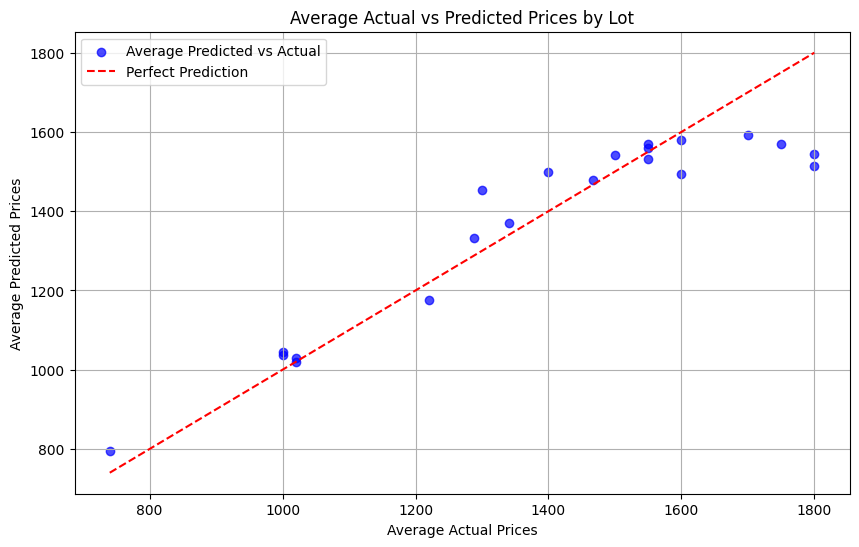

Accuracy of Predicted Averages: 94.61%


In [119]:
from sklearn.metrics import mean_absolute_error

# Calculate the average predicted price and actual price for each lot
avg_actual_price_by_lot = df.groupby('Lot Number')['Actual Price'].mean()
avg_pred_price_by_lot = df.groupby('Lot Number')['Predicted Price'].mean()

# Calculate the accuracy of the predicted average vs true average
# Mean Absolute Error (MAE) between actual and predicted averages for each lot
mae = mean_absolute_error(avg_actual_price_by_lot, avg_pred_price_by_lot)
accuracy = 100 - (mae / avg_actual_price_by_lot.mean()) * 100

# Visualize the average actual vs predicted prices for each lot
plt.figure(figsize=(10, 6))
plt.scatter(avg_actual_price_by_lot, avg_pred_price_by_lot, color='blue', label='Average Predicted vs Actual', alpha=0.7)
plt.plot([min(avg_actual_price_by_lot), max(avg_actual_price_by_lot)], 
         [min(avg_actual_price_by_lot), max(avg_actual_price_by_lot)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Average Actual Prices')
plt.ylabel('Average Predicted Prices')
plt.title('Average Actual vs Predicted Prices by Lot')
plt.legend()
plt.grid(True)
plt.show()

# Print accuracy of predicted average prices
print(f"Accuracy of Predicted Averages: {accuracy:.2f}%")


## 3D

In [100]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder to reduce features to 2 dimensions
        self.encoder = nn.Sequential(
            nn.Linear(384, 512),  # Match DINOv2 CLS token size
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 3)  # Reduce to 2 dimensions
        )
        # Decoder to reconstruct features (optional, for training)
        self.decoder = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 384)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return encoded, reconstructed

# Initialize the autoencoder model
autoencoder = Autoencoder().to(device)

In [106]:
train_autoencoder(autoencoder, dinov2_model, tea_loader, device, optimizer, criterion, epochs=20)

Epoch 1/20:   6%|▌         | 2/35 [00:00<00:11,  2.92it/s, loss=1.67]

Reconstruction Errors (Sample): [1.7125229 1.723567  1.7838029 1.773447  1.7912229]


Epoch 1/20 - Loss: 0.4871, Accuracy: 44.23%


Epoch 2/20 - Loss: 0.2594, Accuracy: 74.36%


Epoch 3/20 - Loss: 0.2130, Accuracy: 89.47%


Epoch 4/20 - Loss: 0.2008, Accuracy: 93.86%


Epoch 5/20 - Loss: 0.1969, Accuracy: 95.05%


Epoch 6/20 - Loss: 0.1902, Accuracy: 96.15%


Epoch 7/20 - Loss: 0.1755, Accuracy: 97.89%


Epoch 8/20 - Loss: 0.1716, Accuracy: 98.26%


Epoch 9/20 - Loss: 0.1692, Accuracy: 98.53%


Epoch 10/20 - Loss: 0.1678, Accuracy: 98.72%


Epoch 11/20 - Loss: 0.1665, Accuracy: 98.90%


Epoch 12/20 - Loss: 0.1654, Accuracy: 98.90%


Epoch 13/20 - Loss: 0.1646, Accuracy: 98.99%


Epoch 14/20 - Loss: 0.1638, Accuracy: 98.99%


Epoch 15/20 - Loss: 0.1629, Accuracy: 98.99%


Epoch 16/20 - Loss: 0.1623, Accuracy: 99.08%


Epoch 17/20 - Loss: 0.1617, Accuracy: 99.18%


Epoch 18/20 - Loss: 0.1611, Accuracy: 99.18%


Epoch 19/20 - Loss: 0.1605, Accuracy: 99.18%


Epoch 20/20 - Loss: 0.1599, Accuracy: 99.27%


In [107]:
#Extract features and prices for training data
train_features, train_prices,train_lot_numbers = extract_features_dinov2_with_label_encoder(dinov2_model, train_loader, device,autoencoder)
val_features, val_prices , val_lot_numbers= extract_features_dinov2_with_label_encoder(dinov2_model, val_loader, device,autoencoder)

# Convert features and prices to numpy arrays
train_features_np = train_features.numpy()
train_prices_np = train_prices.numpy()
train_lot_numbers_np = train_lot_numbers.numpy()


val_features_np = val_features.numpy()
val_prices_np = val_prices.numpy()
val_lot_numbers_np = val_lot_numbers.numpy()

<ipython-input-24-07838be351ac>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lot_number_list.append(torch.tensor(lot_numbers))  # Ensure lot_numbers are tensors


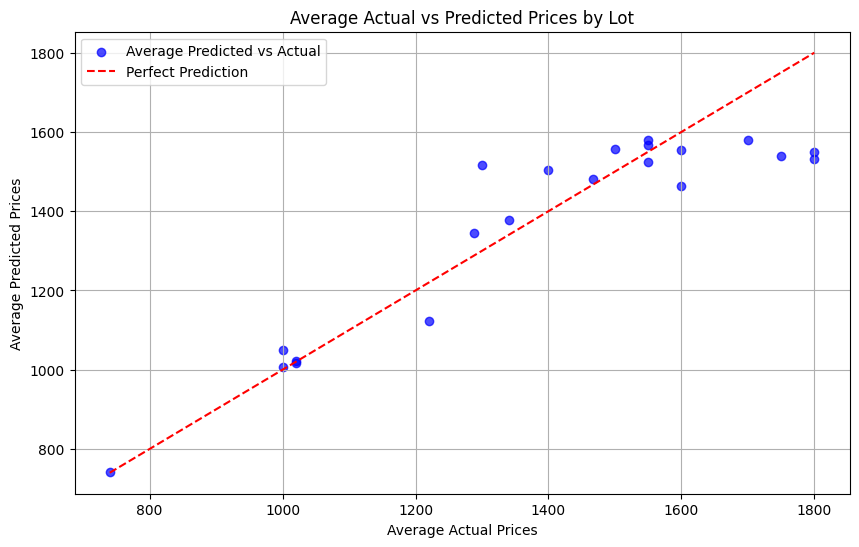

Accuracy of Predicted Averages: 94.00%


In [108]:
X_train, X_val, y_train, y_val = train_features_np,val_features_np,train_prices_np,val_prices_np
# Example: Get predictions for the validation set
regressor = RandomForestRegressor(n_estimators=150, random_state=42)
regressor.fit(X_train, y_train)  # Train on your dataset

# Predict on validation data
y_val_pred = regressor.predict(X_val)

# Create a DataFrame for actual and predicted prices, with lot numbers
df = pd.DataFrame({
    'Actual Price': y_val,
    'Predicted Price': y_val_pred,
    'Lot Number': val_lot_numbers_np,  # Replace with actual lot numbers
})

# Calculate the average predicted price and actual price for each lot
avg_actual_price_by_lot = df.groupby('Lot Number')['Actual Price'].mean()
avg_pred_price_by_lot = df.groupby('Lot Number')['Predicted Price'].mean()

# Calculate the accuracy of the predicted average vs true average
# Mean Absolute Error (MAE) between actual and predicted averages for each lot
mae = mean_absolute_error(avg_actual_price_by_lot, avg_pred_price_by_lot)
accuracy = 100 - (mae / avg_actual_price_by_lot.mean()) * 100

# Visualize the average actual vs predicted prices for each lot
plt.figure(figsize=(10, 6))
plt.scatter(avg_actual_price_by_lot, avg_pred_price_by_lot, color='blue', label='Average Predicted vs Actual', alpha=0.7)
plt.plot([min(avg_actual_price_by_lot), max(avg_actual_price_by_lot)], 
         [min(avg_actual_price_by_lot), max(avg_actual_price_by_lot)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Average Actual Prices')
plt.ylabel('Average Predicted Prices')
plt.title('Average Actual vs Predicted Prices by Lot')
plt.legend()
plt.grid(True)
plt.show()

# Print accuracy of predicted average prices
print(f"Accuracy of Predicted Averages: {accuracy:.2f}%")


In [79]:
print(X_val.shape)
print(val_lot_numbers_np.shape)


(1206, 384)
(1206,)


In [94]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Set up MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

print(f'Number of devices: {strategy.num_replicas_in_sync}')


# Define the neural network model
def build_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))  # First hidden layer
    model.add(Dense(32, activation='relu'))  # Second hidden layer
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mape'])  # Add metrics here
    return model

# Use the strategy to create and compile the model
with strategy.scope():
    model = build_nn_model(X_train.shape[1])


X_train, X_val, y_train, y_val = train_features_np,val_features_np,train_prices_np,val_prices_np

# Train the neural network model with progress displayed
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict on training data
y_train_pred = model.predict(X_train)
train_accuracy = mean_absolute_error(y_train, y_train_pred)
train_accuracy = 100 - (train_accuracy / y_train.mean() * 100)  # To report accuracy as percentage
training_accuracies.append(train_accuracy)

# Predict on validation data
y_val_pred = model.predict(X_val)
val_accuracy = mean_absolute_error(y_val, y_val_pred)
val_accuracy = 100 - (val_accuracy / y_val.mean() * 100)  # To report accuracy as percentage
validation_accuracies.append(val_accuracy)

print(f"Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['mae'], label='Training MAE')  # Add training MAE for visualization
plt.plot(history.history['val_mae'], label='Validation MAE')  # Add validation MAE for visualization
plt.title('Training and Validation Loss & MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss/MAE')
plt.legend()
plt.show()


Number of devices: 2
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: nan - mae: 1082.1571 - mape: 78.9616 - val_loss: 47801.6250 - val_mae: 187.2992 - val_mape: 16.0605
Epoch 2/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: nan - mae: 175.5604 - mape: 14.6060 - val_loss: 24843.6738 - val_mae: 128.6273 - val_mape: 10.6114
Epoch 3/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: nan - mae: 122.2616 - mape: 9.6973 - val_loss: 19548.6895 - val_mae: 111.6103 - val_mape: 8.9437
Epoch 4/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: nan - mae: 109.3169 - mape: 8.5116 - val_loss: 18437.3906 - val_mae: 107.5890 - val_mape: 8.4927
Epoch 5/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: nan - mae: 107.5173 - mape: 8.2667 - val_loss: 17690.5820 - val_mae: 104.1349 - val_mape: 8.0883
Epoch 6/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: nan - mae: 102.8173 - mape: 7.8580 - val_loss: 17520.5508 - val_mae: 102.5206 - val_mape: 7.8355
Epoch 7/20
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: nan

NameError: name 'training_accuracies' is not defined

In [95]:
y_val_pred = model.predict(X_val)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [96]:
y_val_pred = y_val_pred.ravel() 

In [97]:
print(y_val.shape)
print(y_val_pred.shape)
print(val_lot_numbers_np.shape)


(1092,)
(1092,)
(1092,)


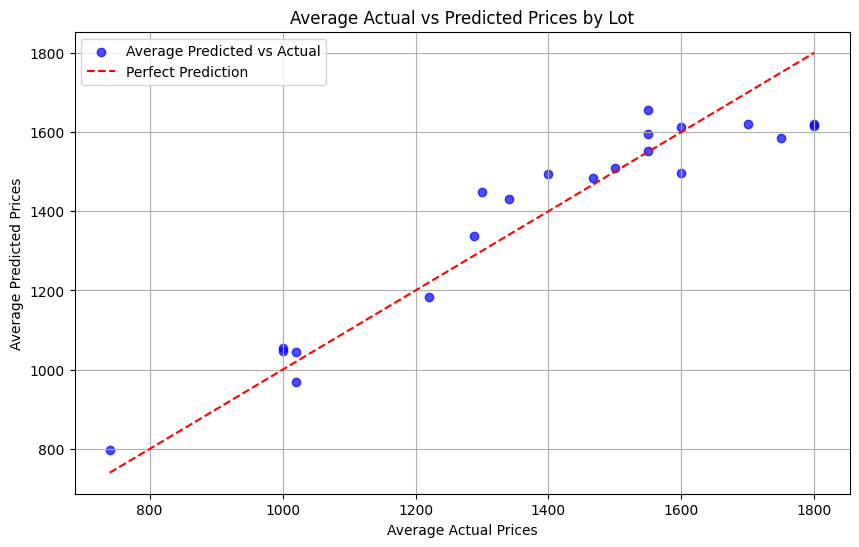

Accuracy of Predicted Averages: 94.65%


In [98]:
df = pd.DataFrame({
    'Actual Price': y_val,
    'Predicted Price': y_val_pred,
    'Lot Number': val_lot_numbers_np,  # Replace with actual lot numbers
})

# Calculate the average predicted price and actual price for each lot
avg_actual_price_by_lot = df.groupby('Lot Number')['Actual Price'].mean()
avg_pred_price_by_lot = df.groupby('Lot Number')['Predicted Price'].mean()

# Calculate the accuracy of the predicted average vs true average
# Mean Absolute Error (MAE) between actual and predicted averages for each lot
mae = mean_absolute_error(avg_actual_price_by_lot, avg_pred_price_by_lot)
accuracy = 100 - (mae / avg_actual_price_by_lot.mean()) * 100

# Visualize the average actual vs predicted prices for each lot
plt.figure(figsize=(10, 6))
plt.scatter(avg_actual_price_by_lot, avg_pred_price_by_lot, color='blue', label='Average Predicted vs Actual', alpha=0.7)
plt.plot([min(avg_actual_price_by_lot), max(avg_actual_price_by_lot)], 
         [min(avg_actual_price_by_lot), max(avg_actual_price_by_lot)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Average Actual Prices')
plt.ylabel('Average Predicted Prices')
plt.title('Average Actual vs Predicted Prices by Lot')
plt.legend()
plt.grid(True)
plt.show()

# Print accuracy of predicted average prices
print(f"Accuracy of Predicted Averages: {accuracy:.2f}%")


In [50]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch


class TeaDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []
        
        # Use os.walk to include files from subdirectories
        for root, _, files in os.walk(folder_path):
            for f in files:
                if f.endswith('.jpg'):
                    self.image_files.append(os.path.join(root, f))  # Store the full path

        # Assuming the filename format is like "some_name_lotnumber_price.jpg"
        self.prices = [
            float(f.split()[2]) for f in self.image_files  # Adjust according to your filename structure
        ]
        self.lot_numbers = [
            float(f.split()[1]) for f in self.image_files  # Handle lot number as float first
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        price = self.prices[idx]
        lot_number = int(self.lot_numbers[idx])  # Convert lot number to int after extracting it as float
        return image, price, lot_number


# Function to split dataset into training and validation sets
def split_dataset(dataset, validation_lot_numbers):
    train_indices = []
    val_indices = []

    for idx, lot_number in enumerate(dataset.lot_numbers):
        if lot_number in validation_lot_numbers:
            val_indices.append(idx)
        else:
            train_indices.append(idx)

    train_set = torch.utils.data.Subset(dataset, train_indices)
    val_set = torch.utils.data.Subset(dataset, val_indices)
    
    return train_set, val_set

# Example usage
folder_path = '/kaggle/input/sampled-tea-full/Sampled_full'
validation_lot_numbers = [ 547, 429, 520]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Load the full dataset
full_dataset = TeaDataset(folder_path=folder_path, transform=transform)

# Split into training and validation sets
train_dataset, val_dataset = split_dataset(full_dataset, validation_lot_numbers)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [47]:
print(len(val_dataset))

1206


In [48]:
# Load the pre-trained DinoV2 model
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
dinov2_model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dinov2_model = dinov2_model.to(device)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [49]:
#Extract features and prices for training data
train_features, train_prices,train_lot_numbers  = extract_features_dinov2_with_label(dinov2_model, train_loader, device)
val_features, val_prices, val_lot_numbers = extract_features_dinov2_with_label(dinov2_model, val_loader, device)

# Convert features and prices to numpy arrays
train_features_np = train_features.numpy()
train_prices_np = train_prices.numpy()
train_lot_numbers_np = train_lot_numbers.numpy()


val_features_np = val_features.numpy()
val_prices_np = val_prices.numpy()
val_lot_numbers_np = val_lot_numbers.numpy()



<ipython-input-19-5c63c4398c89>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lot_number_list.append(torch.tensor(lot_numbers))  # Ensure lot_numbers are tensors


In [50]:
# Function to calculate accuracy percentage
def calculate_accuracy(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    accuracy = 100 - mape
    return accuracy

In [26]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_features_np,val_features_np,train_prices_np,val_prices_np

# Simulated "epochs" by incrementing the number of trees
n_estimators_list = [20, 50, 100, 150]  # Number of trees
training_accuracies = []
validation_accuracies = []

for n_estimators in n_estimators_list:
    # Train a Random Forest regressor with the current number of trees
    regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    regressor.fit(X_train, y_train)
    
    # Evaluate on training data
    y_train_pred = regressor.predict(X_train)
    train_accuracy = calculate_accuracy(y_train, y_train_pred)
    training_accuracies.append(train_accuracy)
    
    # Evaluate on validation data
    y_val_pred = regressor.predict(X_val)
    val_accuracy = calculate_accuracy(y_val, y_val_pred)
    validation_accuracies.append(val_accuracy)

    print(f"Trees: {n_estimators}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, training_accuracies, label='Training Accuracy', marker='o')
plt.plot(n_estimators_list, validation_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy vs Number of Trees')
plt.legend()
plt.grid()
plt.show()


Trees: 20, Training Accuracy: 97.88%, Validation Accuracy: 90.44%
Trees: 50, Training Accuracy: 97.99%, Validation Accuracy: 90.56%
Trees: 100, Training Accuracy: 98.02%, Validation Accuracy: 90.60%
Trees: 150, Training Accuracy: 98.01%, Validation Accuracy: 90.57%


NameError: name 'plt' is not defined

Trees: 50, Training Accuracy: 92.12%, Validation Accuracy: 91.32%
Trees: 100, Training Accuracy: 92.05%, Validation Accuracy: 91.31%
Trees: 150, Training Accuracy: 92.04%, Validation Accuracy: 91.28%


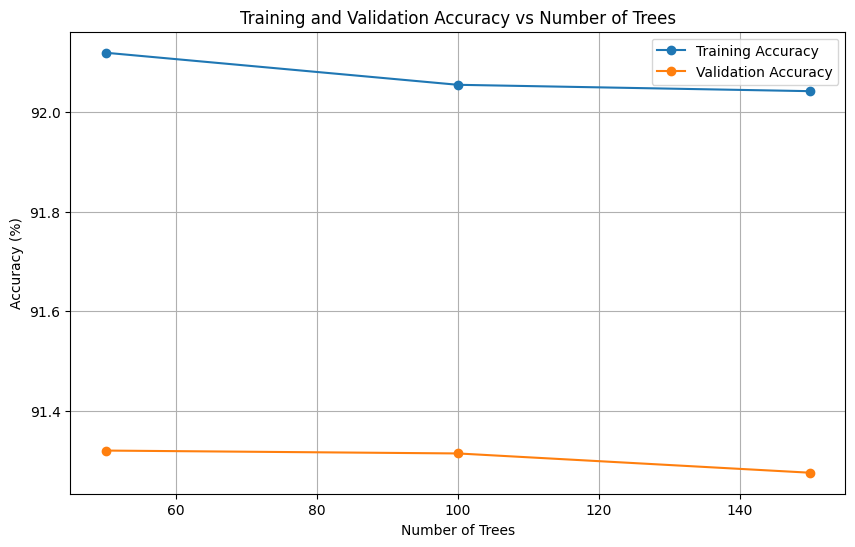

Trees: 20, Training Accuracy: 97.88%, Validation Accuracy: 90.44%
Trees: 50, Training Accuracy: 97.99%, Validation Accuracy: 90.56%


KeyboardInterrupt: 

In [28]:
from sklearn.ensemble import AdaBoostRegressor
import numpy as np

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_features_np,val_features_np,train_prices_np,val_prices_np

# Simulated "epochs" by incrementing the number of trees
n_estimators_list = [50, 100, 150]  # Number of trees
training_accuracies = []
validation_accuracies = []

for n_estimators in n_estimators_list:
    # Train a Random Forest regressor with the current number of trees
    regressor = AdaBoostRegressor(n_estimators=n_estimators, random_state=42)
    regressor.fit(X_train, y_train)
    
    # Evaluate on training data
    y_train_pred = regressor.predict(X_train)
    train_accuracy = calculate_accuracy(y_train, y_train_pred)
    training_accuracies.append(train_accuracy)
    
    # Evaluate on validation data
    y_val_pred = regressor.predict(X_val)
    val_accuracy = calculate_accuracy(y_val, y_val_pred)
    validation_accuracies.append(val_accuracy)

    print(f"Trees: {n_estimators}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

# Plot training and validation accuracies
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, training_accuracies, label='Training Accuracy', marker='o')
plt.plot(n_estimators_list, validation_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy vs Number of Trees')
plt.legend()
plt.grid()
plt.show()



In [55]:
X_train, X_val, y_train, y_val = train_features_np,val_features_np,train_prices_np,val_prices_np


regressor = AdaBoostRegressor(n_estimators=50, random_state=30)
regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
train_accuracy = calculate_accuracy(y_train, y_train_pred)
training_accuracies.append(train_accuracy)
    
    # Evaluate on validation data
y_val_pred = regressor.predict(X_val)
val_accuracy = calculate_accuracy(y_val, y_val_pred)
validation_accuracies.append(val_accuracy)


print(f"Trees: {n_estimators}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

Trees: 100, Training Accuracy: 92.11%, Validation Accuracy: 91.75%


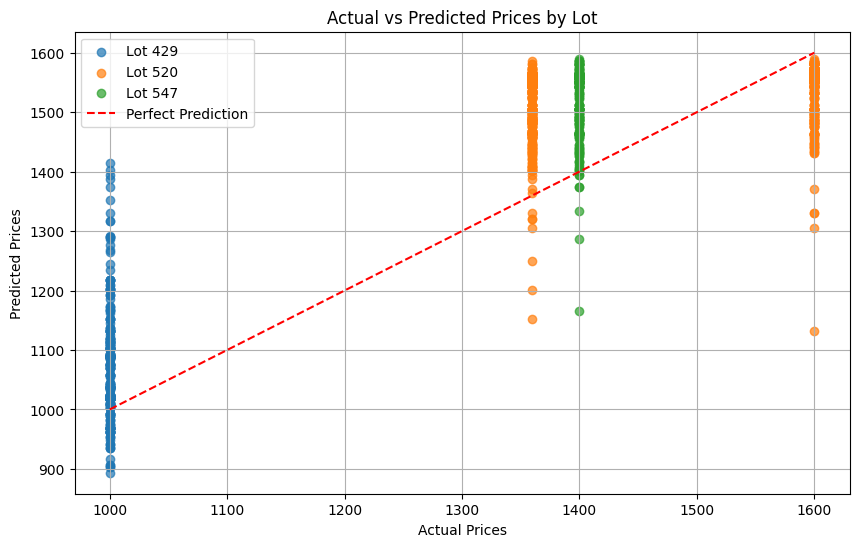

In [56]:
X_train, X_val, y_train, y_val = train_features_np,val_features_np,train_prices_np,val_prices_np
# Create a DataFrame for actual and predicted prices, with lot numbers
df = pd.DataFrame({
    'Actual Price': y_val,
    'Predicted Price': y_val_pred,
    'Lot Number': val_lot_numbers_np,  # Replace with actual lot numbers
})

# Calculate the average predicted price for each lot
avg_pred_price_by_lot = df.groupby('Lot Number')['Predicted Price'].mean()

# Visualize actual vs predicted prices for each lot
plt.figure(figsize=(10, 6))
for lot in avg_pred_price_by_lot.index:
    actual_prices_for_lot = df[df['Lot Number'] == lot]['Actual Price']
    predicted_prices_for_lot = df[df['Lot Number'] == lot]['Predicted Price']
    
    plt.scatter(actual_prices_for_lot, predicted_prices_for_lot, label=f'Lot {lot}', alpha=0.7)

# Add perfect prediction line
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices by Lot')
plt.legend()
plt.grid(True)
plt.show()

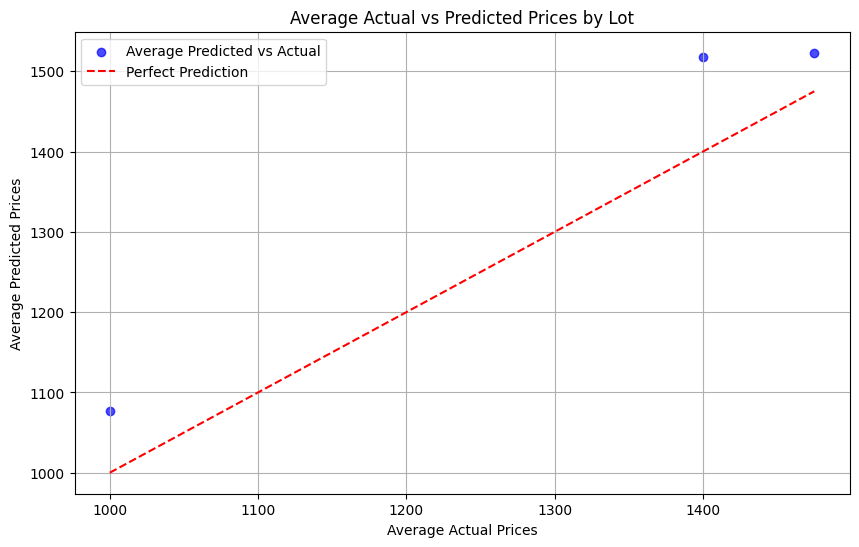

Accuracy of Predicted Averages: 93.75%


In [57]:
# Create a DataFrame for actual and predicted prices, with lot numbers
df = pd.DataFrame({
    'Actual Price': y_val,
    'Predicted Price': y_val_pred,
    'Lot Number': val_lot_numbers_np,  # Replace with actual lot numbers
})


#Calculate the average predicted price and actual price for each lot
avg_actual_price_by_lot = df.groupby('Lot Number')['Actual Price'].mean()
avg_pred_price_by_lot = df.groupby('Lot Number')['Predicted Price'].mean()

# Calculate the accuracy of the predicted average vs true average
# Mean Absolute Error (MAE) between actual and predicted averages for each lot
mae = mean_absolute_error(avg_actual_price_by_lot, avg_pred_price_by_lot)
accuracy = 100 - (mae / avg_actual_price_by_lot.mean()) * 100

# Visualize the average actual vs predicted prices for each lot
plt.figure(figsize=(10, 6))
plt.scatter(avg_actual_price_by_lot, avg_pred_price_by_lot, color='blue', label='Average Predicted vs Actual', alpha=0.7)
plt.plot([min(avg_actual_price_by_lot), max(avg_actual_price_by_lot)], 
         [min(avg_actual_price_by_lot), max(avg_actual_price_by_lot)], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Average Actual Prices')
plt.ylabel('Average Predicted Prices')
plt.title('Average Actual vs Predicted Prices by Lot')
plt.legend()
plt.grid(True)
plt.show()

# Print accuracy of predicted average prices
print(f"Accuracy of Predicted Averages: {accuracy:.2f}%")


# Using Densenet Pretrained Model

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Custom Dataset to extract prices from filenames
class TeaDataset:
    def __init__(self, folder_path, img_size=(512, 512)):
        self.folder_path = folder_path
        self.img_size = img_size
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
        self.prices = [float(f.split()[2]) for f in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = load_img(img_path, target_size=self.img_size)
        image = img_to_array(image) / 255.0  # Normalize to [0, 1]
        price = self.prices[idx]
        return image, price

# Dataset preprocessing
def load_dataset(dataset_path, img_size=(512, 512)):
    dataset = TeaDataset(folder_path=dataset_path, img_size=img_size)
    images, prices = zip(*[dataset[i] for i in range(len(dataset))])
    return np.array(images), np.array(prices)

# Load train and validation datasets
train_dataset_path = '/kaggle/input/sampled-tea-full/Sampled_full/Train'
val_dataset_path = '/kaggle/input/sampled-tea-full/Sampled_full/Val'
train_images, train_prices = load_dataset(train_dataset_path)
val_images, val_prices = load_dataset(val_dataset_path)

# Load the pre-trained DenseNet model
densenet_model_path = '/kaggle/input/desnsenet-grades/best_densenet121_model_c2.keras'
densenet_model = load_model(densenet_model_path)

# Remove the classification head
feature_extractor = Model(inputs=densenet_model.input, outputs=densenet_model.layers[-2].output)

# Feature extraction function
def extract_features(model, images):
    return model.predict(images, batch_size=32)

# Extract features for train and validation sets
train_features = extract_features(feature_extractor, train_images)
val_features = extract_features(feature_extractor, val_images)

# Apply t-SNE for dimensionality reduction (combine train and validation)
features = np.vstack((train_features, val_features))
prices = np.hstack((train_prices, val_prices))
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Visualize the features with t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=prices, cmap='viridis', s=50)
plt.colorbar(scatter, label='Price')
plt.title('t-SNE Visualization of Tea Sample Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
